In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import argparse
from ddpg_torch.ddpg_torch import Agent
import gym
import numpy as np
from lifting_rl.linkage_env import LinkageEnv

from livelossplot import PlotLosses

In [2]:
params = {
    "N_LINKS": 2,
    "GOAL_POS": np.array([np.pi / 4, 0], dtype=np.float32),
    "INIT_STATE": np.array([np.pi / 4, np.pi / 4, 0, 0], dtype=np.float32),
    "PARAM_VALS": np.array([9.81, 0.4, 1, 0.4, 1], dtype=np.float32),
    "OBS_LOW": np.array([-np.pi/4, -np.pi/4, -8, -8], dtype=np.float32),
    "OBS_HIGH": np.array(
        [3*np.pi/4, 3*np.pi/4,  8, 8], dtype=np.float32
    ),
    "ACT_LOW": -30,
    "ACT_HIGH": 30,
    "TIME_STEP": 0.01,
    "VIDEO_FPS": 30,
}


In [3]:
angles_file = "/home/mans/git/human-body-model-dynamics/data/skeleton_angles.csv"

In [4]:
env = LinkageEnv(angles_file, params, verbose=0)

observation_space:  Box(4,)
action_space:  Box(2,)


In [5]:
agent = Agent(
    lr_actor=0.000025,
    lr_critic=0.00025,
    input_dims=[10],
    tau=0.001,
    env=env,
    batch_size=64,
    layer1_size=400,
    layer2_size=300,
    n_actions=2,
)

In [6]:
np.random.seed(0)

In [7]:
liveloss = PlotLosses()

In [8]:
score_history = []

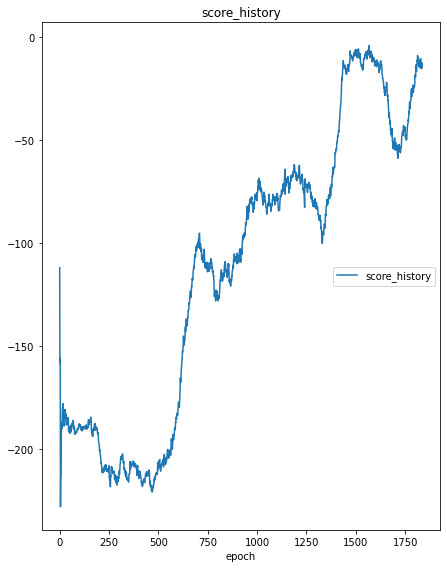

score_history
	score_history    	 (min: -228.164, max:   -4.214, cur:  -14.850)
episode 1836 score -132.10 100 game average -14.85
[ 0.9846861 -0.9856842]
[ 0.9846861 -0.9856842]
[ 0.96941227 -0.9790698 ]
[ 0.96941227 -0.9790698 ]
[ 0.95305634 -1.003146  ]
[ 0.95305634 -1.003146  ]
[ 0.9191041 -0.9783693]
[ 0.9191041 -0.9783693]
[ 0.9362953  -0.99115837]
[ 0.9362953  -0.99115837]
[ 0.9730643 -1.0174649]
[ 0.9730643 -1.0174649]
[ 0.9695999 -1.0066913]
[ 0.9695999 -1.0066913]
[ 0.9660278 -1.007142 ]
[ 0.9660278 -1.007142 ]
[ 0.9984421 -0.9671875]
[ 0.9984421 -0.9671875]
[ 0.86452615 -0.96259654]
[ 0.86452615 -0.96259654]
[-1.0146182 -0.9739303]
[-1.0146182 -0.9739303]
[-1.0070661   0.06397352]
[-1.0070661   0.06397352]
[-1.0185423   0.91785884]
[-1.0185423   0.91785884]
[-0.9096091  -0.38817418]
[-0.9096091  -0.38817418]
[-0.7514575  -0.40230098]
[-0.7514575  -0.40230098]
[-0.6236418 -0.1975921]
[-0.6236418 -0.1975921]
[-0.28729033 -0.17407595]
[-0.28729033 -0.17407595]
[-0.2715836   0.1

[-0.05179035  0.23762128]
[-0.05179035  0.23762128]
[-0.01686741  0.25113836]
[-0.01686741  0.25113836]
[-0.01180676  0.25018993]
[-0.01180676  0.25018993]
[0.02902388 0.29533195]
[0.02902388 0.29533195]
[0.0740706 0.3168168]
[0.0740706 0.3168168]
[0.14091156 0.34768516]
[0.14091156 0.34768516]
[0.17562553 0.39105368]
[0.17562553 0.39105368]
[0.23694889 0.4327169 ]
[0.23694889 0.4327169 ]
[0.2743288  0.44767076]
[0.2743288  0.44767076]
[0.3103735  0.41569462]
[0.3103735  0.41569462]
[0.23222151 0.41071212]
[0.23222151 0.41071212]
[0.20280552 0.34923482]
[0.20280552 0.34923482]
[0.1386376  0.27835935]
[0.1386376  0.27835935]
[0.07221101 0.19084695]
[0.07221101 0.19084695]
[-0.02464968  0.19203806]
[-0.02464968  0.19203806]
[-0.07475364  0.17293632]
[-0.07475364  0.17293632]
[-0.15452102  0.15471214]
[-0.15452102  0.15471214]
[-0.1460147   0.12169684]
[-0.1460147   0.12169684]
[-0.17275563  0.12211984]
[-0.17275563  0.12211984]
[-0.17828937  0.0933144 ]
[-0.17828937  0.0933144 ]
[-0.1901

KeyboardInterrupt: 

In [9]:
for i in range(100000):
    done = False
    score = 0
    obs = env.reset()
    agent.noise.reset()
    while not done:
        env.render()
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state

    score_history.append(score)

    metrics = {"score_history": np.mean(score_history[-100:])}
    liveloss.update(metrics)
    liveloss.send()
    print(
        "episode",
        i,
        "score %.2f" % score,
        "100 game average %.2f" % np.mean(score_history[-100:]),
    )
env.close()